## 1. Data Inventory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/ucla_capstone'


Mounted at /content/drive


In [ ]:
import pandas as pd, glob, os

mort_acct = pd.read_csv(os.path.join(DATA_DIR, 'mortgage_accounts.csv'))
mort_txn = pd.read_csv(os.path.join(DATA_DIR, 'mortgage_transactions.csv'))

for name, df in [('ACCOUNTS', mort_acct), ('TRANSACTIONS', mort_txn)]:
    print(f'\n===== MORTGAGE {name} =====')
    display(df.head(3))
    df.info()



===== MORTGAGE ACCOUNTS =====


,accountId,accountNumberDisplay,accountType,balanceType,currency,description,accountOpenedDate,nickname,productName,status
0,2642618000,******4890,MORTGAGE,LIABILITY,USD,GENERIC COMPANY MORTGAGE,2023-03-17,MORTGAGE,GENERIC COMPANY MORTGAGE,OPEN
1,2642618001,******7945,MORTGAGE,LIABILITY,USD,GENERIC COMPANY MORTGAGE,2014-01-03,MORTGAGE,GENERIC COMPANY MORTGAGE,OPEN
2,2642618002,******5297,MORTGAGE,LIABILITY,USD,GENERIC COMPANY MORTGAGE,2020-05-02,MORTGAGE,GENERIC COMPANY MORTGAGE,OPEN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   accountId             100 non-null    int64 
 1   accountNumberDisplay  100 non-null    object
 2   accountType           100 non-null    object
 3   balanceType           100 non-null    object
 4   currency              100 non-null    object
 5   description           100 non-null    object
 6   accountOpenedDate     100 non-null    object
 7   nickname              100 non-null    object
 8   productName           100 non-null    object
 9   status                100 non-null    object
dtypes: int64(1), object(9)
memory usage: 7.9+ KB

===== MORTGAGE TRANSACTIONS =====


,accountId,transactionId,postedTimestamp,transactionTimestamp,description,debitCreditMemo,category,status,amount,displayName,transactionType,principalAmount,interestAmount,feesAmount
0,2642618000,d6bd56e4-2d44-4383-900d-7e402ae6a1e4,2024-05-01,2024-04-30,PAYMENT,CREDIT,Mortgage/Rent,POSTED,2684.12,Mortgage - 5932,PAYMENT,1993.83,690.29,0.0
1,2642618000,5c749a34-bb4e-4026-bd19-7363dd57b758,2024-04-01,2024-03-31,PAYMENT,CREDIT,Mortgage/Rent,POSTED,2252.87,Mortgage - 7366,PAYMENT,1525.16,727.71,0.0
2,2642618000,66ab8c17-58d7-47b5-99a5-5c55185ca723,2024-03-02,2024-03-01,PAYMENT,CREDIT,Mortgage/Rent,POSTED,2401.49,Mortgage - 9821,PAYMENT,1515.84,885.65,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accountId             1200 non-null   int64  
 1   transactionId         1200 non-null   object 
 2   postedTimestamp       1200 non-null   object 
 3   transactionTimestamp  1200 non-null   object 
 4   description           1200 non-null   object 
 5   debitCreditMemo       1200 non-null   object 
 6   category              1200 non-null   object 
 7   status                1200 non-null   object 
 8   amount                1200 non-null   float64
 9   displayName           1200 non-null   object 
 10  transactionType       1200 non-null   object 
 11  principalAmount       1200 non-null   float64
 12  interestAmount        1200 non-null   float64
 13  feesAmount            1200 non-null   float64
dtypes: float64(4), int64(1), object(9)
memory usage: 131.4+ KB


In [ ]:
def quick_profile(df, name):
    profile = pd.DataFrame({
        'column' : df.columns,
        'dtype' : df.dtypes.astype(str),
        'null_%' : df.isnull().mean().round(3)*100,
        'n_unique' : df.nunique()
    })
    profile.to_csv(os.path.join(DATA_DIR, f'{name}_profile.csv'), index=False)

quick_profile(mort_acct, 'mortgage_accounts')
quick_profile(mort_txn, 'mortgage_transactions')
print('Profiles saved to mortgage_accounts_profile.csv & mortgage_transactions_profile.csv')


Profiles saved to mortgage_accounts_profile.csv & mortgage_transactions_profile.csv


None of them are incomplete or have null values.

全部都没有残缺空值

In [ ]:
mort_txn['transactionTimestamp'] = pd.to_datetime(mort_txn['transactionTimestamp'])
mort_txn['postedTimestamp'] = pd.to_datetime(mort_txn['postedTimestamp'])
for col in ['amount','principalAmount','interestAmount','feesAmount']:
    mort_txn[col] = pd.to_numeric(mort_txn[col], errors='coerce')

# main key uniqueness
dups = mort_txn.duplicated(['accountId','transactionId']).sum()
print('duplicate (accountId, transactionId):', dups)

# possibale future date
import pandas as pd
future = (mort_txn['transactionTimestamp'] > pd.Timestamp.today()).sum()
print('future‐dated rows:', future)


duplicate (accountId, transactionId): 0
future‐dated rows: 0


## 2. Data cleaning

In [ ]:
import pandas as pd, numpy as np, os
from datetime import date

DATA_DIR = '/content/drive/MyDrive/ucla_capstone'

txn = pd.read_csv(os.path.join(DATA_DIR, 'mortgage_transactions.csv'))
acct = pd.read_csv(os.path.join(DATA_DIR, 'mortgage_accounts.csv'))

# date
txn['transactionTimestamp'] = pd.to_datetime(txn['transactionTimestamp'])
txn['postedTimestamp'] = pd.to_datetime(txn['postedTimestamp'])

# amount
num_cols = ['amount','principalAmount','interestAmount','feesAmount']
txn[num_cols] = txn[num_cols].apply(pd.to_numeric, errors='coerce')

today = pd.Timestamp(date.today())
txn = txn[(txn['transactionTimestamp'] <= today) &
          (txn['postedTimestamp']      <= today)]

# if postedTimestamp < transactTimestamp then identify as abnormal and remove
txn = txn[txn['postedTimestamp'] >= txn['transactionTimestamp']]

# main key uniqueness
dups = txn.duplicated(['accountId','transactionId']).sum()
assert dups == 0, f'{dups} duplicated (accountId, transactionId) rows!'

# Financial derivatives column
txn['abs_amount'] = txn['amount'].abs()
txn['is_negative'] = txn['amount'] < 0            # Mortgage PAYMENT is positive
txn['p_i_f_sum'] = txn[['principalAmount','interestAmount','feesAmount']].sum(axis=1)

# if mismatch > 1 dollor the identify as abnormal and remove
txn['amount_mismatch'] = (txn['amount'] - txn['p_i_f_sum']).abs() > 1

txn['is_weekend'] = txn['transactionTimestamp'].dt.weekday >= 5
txn['year_month'] = txn['transactionTimestamp'].dt.to_period('M')

# Repetitive amount count (within the account)
dup_stats = (txn.groupby(['accountId','amount'])
                .size().reset_index(name='dup_amt_cnt'))
txn = txn.merge(dup_stats, on=['accountId','amount'], how='left')

# output
clean_path = os.path.join(DATA_DIR, 'mortgage_transactions_clean.parquet')
txn.to_parquet(clean_path, index=False)
print(f'Mortgage clean file saved to {clean_path}')


Mortgage clean file saved to /content/drive/MyDrive/ucla_capstone/mortgage_transactions_clean.parquet


## 3. Account - Transaction Association

In [ ]:
# Keep only the necessary account columns
acct_keep = ['accountId','accountOpenedDate','status']
acct = acct[acct_keep]

master = txn.merge(acct, on='accountId', how='left', validate='many_to_one')
master_path = os.path.join(DATA_DIR, 'mortgage_master.parquet')
master.to_parquet(master_path, index=False)
print('Master table saved to', master_path)


Master table saved to /content/drive/MyDrive/ucla_capstone/mortgage_master.parquet


## 4. Mortgage Feature Engineering

In [ ]:
import pandas as pd, numpy as np, os
from scipy.stats import zscore

DATA_DIR = '/content/drive/MyDrive/ucla_capstone'
df = pd.read_parquet(os.path.join(DATA_DIR, 'mortgage_master.parquet'))

# By time in ascending order within the same account
df = df.sort_values(['accountId', 'transactionTimestamp'])



In [ ]:
####################################
# Transaction-level derived features
####################################

# Z-score
df['amount_z'] = df.groupby('accountId')['amount'].transform(lambda x: zscore(x, ddof=0))

# Time interval
df['days_since_prev'] = df.groupby('accountId')['transactionTimestamp'].diff().dt.days.fillna(0)
df['days_until_next'] = df.groupby('accountId')['transactionTimestamp'].diff(-1).abs().dt.days.fillna(0)

# 3 transaction - Window
df['rolling_mean_3'] = df.groupby('accountId')['amount'].transform(
    lambda x: x.rolling(3, min_periods=1).mean())
df['rolling_std_3'] = df.groupby('accountId')['amount'].transform(
    lambda x: x.rolling(3, min_periods=1).std().fillna(0))

# Composition ratio
for part in ['principalAmount', 'interestAmount', 'feesAmount']:
    prefix = part.split('Amount')[0]
    df[f'{prefix}_ratio'] = (
        df[part] / df['amount'].replace(0, np.nan)
    ).fillna(0)


# Consistency & Late Payments
df['amount_match_flag'] = (df['amount_mismatch'] == False).astype(int)
df['overdue_flag'] = (df['days_since_prev'] > 40).astype(int)

#################################################
# Account-level aggregated features (per-account)
#################################################

agg = (df
   .assign(is_negative = df['amount'] < 0,
        overdue = df['overdue_flag'])
   .groupby('accountId')
   .agg(
       txn_cnt = ('transactionId','nunique'),
       mean_amt = ('amount','mean'),
       std_amt = ('amount','std'),
       max_abs_amt = ('abs_amount','max'),
       neg_ratio = ('is_negative','mean'),
       avg_days_between = ('days_since_prev', lambda x: x.replace(0,np.nan).mean()),
       overdue_ratio = ('overdue','mean'),
       sum_principal = ('principalAmount','sum'),
       sum_interest = ('interestAmount','sum'),
       sum_fees = ('feesAmount','sum'),
       first_txn = ('transactionTimestamp','min'),
       last_txn = ('transactionTimestamp','max')
   )
   .reset_index()
)

# Proportion of derivative interest / fees
agg['interest_pct_total'] = agg['sum_interest'] / (agg['sum_principal'] + 1e-9)
agg['fees_pct_total'] = agg['sum_fees'] / (agg['sum_principal'] + 1e-9)
agg.drop(columns=['sum_principal','sum_interest','sum_fees'], inplace=True)

# Active Months & Account Lifespan
agg['active_months'] = df.groupby('accountId')['year_month'].nunique().values
agg['account_age_days'] = (agg['last_txn'] - agg['first_txn']).dt.days
agg.drop(columns=['first_txn','last_txn'], inplace=True)


feature_df = df.merge(agg, on='accountId', how='left', validate='many_to_one')
print('Feature shape:', feature_df.shape)


feature_path = os.path.join(DATA_DIR, 'mortgage_features.parquet')
feature_df.to_parquet(feature_path, index=False)
print(f'Mortgage features saved to {feature_path}')


Feature shape: (1200, 44)
Mortgage features saved to /content/drive/MyDrive/ucla_capstone/mortgage_features.parquet


## 5. rules & rule_score

| rule number                  | logic                                                | Background / Trigger Threshold                                   |
| --------------------- | ------------------------------------------------- | ------------------------------------------- |
| **R1\_amt\_spike**    | `abs_amount > 1.8 × rolling_mean_3`               | The current repayment amount has increased by more than 80% compared to the average of the last 3 periods.                     |
| **R2\_amt\_mismatch** | `amount_match_flag == 0`                          | Principal + interest + fees imbalance (more than $1 difference) |
| **R3\_overdue**       | `overdue_flag == 1`                               | The interval between two payments > 40 days (assuming monthly supply ≤ 40 days)                 |
| **R4\_freq\_burst**   | `(days_since_prev < 15) & (days_until_next < 15)` | Two consecutive repayments within 15 days, extremely frequent                            |
| **R5\_neg\_amount**   | `is_negative == True`                             | Negative amount appears in the repayment (refund / reversal)                            |
| **R6\_weekend\_pay**  | `is_weekend == True`                              | Repayment on the weekend - quite rare.                                     |
| **R7\_high\_fees**    | `fees_ratio > 0.10`                               | The handling fee exceeds 10% of the repayment amount.                             |
| **R8\_low\_interest** | `interest_ratio < 0.25`                           | The interest proportion is too low. There may be misalignment of fields or abnormal deductions.                          |


In [ ]:
import pandas as pd, os, numpy as np

DATA_DIR = '/content/drive/MyDrive/ucla_capstone'
feat = pd.read_parquet(os.path.join(DATA_DIR, 'mortgage_features.parquet'))

rules = {
    'R1_amt_spike': feat['abs_amount'] > 1.8 * feat['rolling_mean_3'],
    'R2_amt_mismatch': feat['amount_match_flag'] == 0,
    'R3_overdue': feat['overdue_flag'] == 1,
    'R4_freq_burst': (feat['days_since_prev'] < 15) & (feat['days_until_next'] < 15),
    'R5_neg_amount': feat['is_negative'],
    'R6_weekend_pay': feat['is_weekend'],
    'R7_high_fees': feat['fees_ratio'] > 0.10,
    'R8_low_interest': feat['interest_ratio'] < 0.25
}

# New rule column
for col, cond in rules.items():
    feat[col] = cond.astype(int)

rule_cols = list(rules.keys())
feat['rule_score'] = feat[rule_cols].mean(axis=1)   # 0 - 1. The more hits, the higher the score.

# save the output
feat_rules_path = os.path.join(DATA_DIR, 'mortgage_features_rules.parquet')
feat.to_parquet(feat_rules_path, index=False)
print(f'Mortgage feature+rule file saved to {feat_rules_path} ({feat.shape})')


Mortgage feature+rule file saved to /content/drive/MyDrive/ucla_capstone/mortgage_features_rules.parquet ((1200, 53))


## 6. Train + Score the Mortgage Model

**iforest**

In [ ]:
import pandas as pd, numpy as np, os, joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline

DATA_DIR = '/content/drive/MyDrive/ucla_capstone'
feat = pd.read_parquet(os.path.join(DATA_DIR, 'mortgage_features_rules.parquet'))

# Select numerical features
num_cols = [
    'amount_z','days_since_prev','rolling_mean_3','rolling_std_3',
    'overdue_flag','fees_ratio','interest_ratio','dup_amt_cnt',
    'txn_cnt','neg_ratio','avg_days_between','max_abs_amt'
]
X = feat[num_cols].fillna(0).values

# Build pipeline: Scaler + IF
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('if', IsolationForest(
        n_estimators=200,
        contamination=0.03,    # The mortgage default rate is slightly higher at 3%.
        random_state=42
    ))
])
pipe.fit(X)

# decision_function: 0-1 normalization: The larger the value, the more abnormal it is.
raw = pipe['if'].decision_function(pipe['sc'].transform(X))
model_score = (-raw - (-raw).min()) / ((-raw).max() - (-raw).min())
feat['model_score'] = model_score

# Integration model score + Rule score
ALPHA, BETA = 0.7, 0.3
feat['final_score'] = ALPHA*feat['model_score'] + BETA*feat['rule_score']

def to_label(s):
    if s >= np.percentile(feat['final_score'], 99):  return 'FRAUDULENT'
    if s >= np.percentile(feat['final_score'], 97):  return 'HIGH_RISK'
    if s >= np.percentile(feat['final_score'], 90):  return 'UNUSUAL'
    return 'NORMAL'
feat['label'] = feat['final_score'].apply(to_label)

# Save the model and the score
joblib.dump(pipe, os.path.join(DATA_DIR, 'mortgage_iforest.pkl'))
feat.to_parquet(os.path.join(DATA_DIR, 'mortgage_scored.parquet'), index=False)
print('Saved to mortgage_scored.parquet  |  Label dist:')
print(feat['label'].value_counts())


Saved to mortgage_scored.parquet  |  Label dist:
label
NORMAL        1080
UNUSUAL         84
HIGH_RISK       24
FRAUDULENT      12
Name: count, dtype: int64


**pyod**

In [ ]:
!pip install -qU pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
# =========================================
# Mortgage PyOD Ensemble Scoring Pipeline
# UCLA Capstone – Anomaly Detection
# =========================================


import os, joblib, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pyod.models.iforest      import IForest
from pyod.models.lof          import LOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.copod        import COPOD
from pyod.models.cblof        import CBLOF

# parameters
DATA_DIR = '/content/drive/MyDrive/ucla_capstone'
IN_FILE = 'mortgage_features_rules.parquet'
OUT_FILE = 'mortgage_scored_pyod.parquet'
MODEL_DIR = os.path.join(DATA_DIR, 'models_mortgage')
os.makedirs(MODEL_DIR, exist_ok=True)

ALPHA = 0.7        # model score weight
BETA = 0.3        # rule score weight
CONTAM = 0.03      # Expected Mortgage Default Rate (3%)

# read data
feat = pd.read_parquet(os.path.join(DATA_DIR, IN_FILE))

num_cols = [
    'amount_z','days_since_prev','rolling_mean_3','rolling_std_3',
    'overdue_flag','fees_ratio','interest_ratio','dup_amt_cnt',
    'txn_cnt','neg_ratio','avg_days_between','max_abs_amt'
]
X_raw = feat[num_cols].fillna(0).values
scaler = StandardScaler().fit(X_raw)
X = scaler.transform(X_raw)

# define model

ae_model = AutoEncoder(
    contamination=CONTAM,
    hidden_neuron_list=[32, 16, 32],
    epoch_num=40,
    batch_size=32,
    random_state=42,
)

MODELS = {
    'iforest': IForest(contamination=CONTAM, n_estimators=250, random_state=42),
    'lof': LOF(contamination=CONTAM, n_neighbors=20),
    'ae': ae_model,
    'copod': COPOD(contamination=CONTAM),
    'cblof': CBLOF(contamination=CONTAM, n_clusters=10, random_state=42)
}

scores = {}
for name, clf in MODELS.items():
    pipe = Pipeline([('model', clf)])
    pipe.fit(X)
    raw = pipe['model'].decision_scores_            # larger, more abnormal
    scores[name] = (raw - raw.min()) / (raw.max() - raw.min())   # nomalization 0-1
    joblib.dump(pipe, os.path.join(MODEL_DIR, f'{name}.pkl'))    # save model
    print(f'{name:<8s}  mean={scores[name].mean():.3f}')

# Model averaging and fusion
feat['model_score'] = pd.DataFrame(scores).mean(axis=1)

# Integration rules section
feat['final_score'] = ALPHA*feat['model_score'] + BETA*feat['rule_score']

# Quartile mapping with four labels
p90, p97, p99 = np.percentile(feat['final_score'], [90, 97, 99])
def to_label(s):
    if s >= p99: return 'FRAUDULENT'   # ~1%
    if s >= p97: return 'HIGH_RISK'    # ~2-3%
    if s >= p90: return 'UNUSUAL'      # ~10%
    return 'NORMAL'
feat['label'] = feat['final_score'].apply(to_label)

# save output
feat.to_parquet(os.path.join(DATA_DIR, OUT_FILE), index=False)
print('\nMortgage scoring complete ➜', OUT_FILE)
print('\nLabel distribution:\n', feat['label'].value_counts(normalize=True)\
      .apply(lambda x: f'{x*100:.2f}%'))


iforest   mean=0.255
lof       mean=0.139


Training: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]


ae        mean=0.332
copod     mean=0.232
cblof     mean=0.287

Mortgage scoring complete ➜ mortgage_scored_pyod.parquet

Label distribution:
 label
NORMAL        90.00%
UNUSUAL        7.00%
HIGH_RISK      2.00%
FRAUDULENT     1.00%
Name: proportion, dtype: object


## 7. visualization

Isolation Forest baseline  →  P90=0.3647,  P97=0.5129,  P99=0.5926


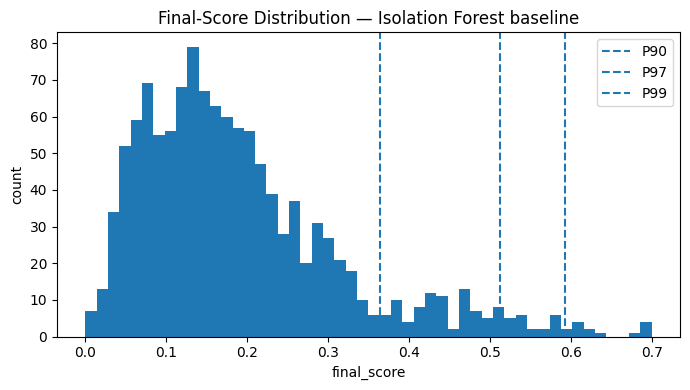

PyOD Ensemble  →  P90=0.3096,  P97=0.3886,  P99=0.4626


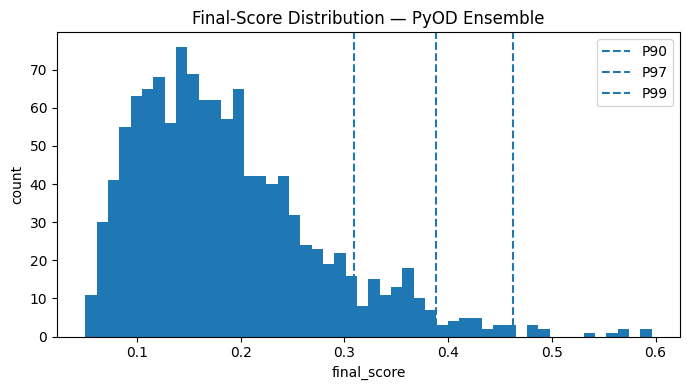

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os

DATA_DIR = '/content/drive/MyDrive/ucla_capstone'
IF_FILE = 'mortgage_scored.parquet' # Isolation-Forest
PYOD_FILE = 'mortgage_scored_pyod.parquet' # PyOD

df_if = pd.read_parquet(os.path.join(DATA_DIR, IF_FILE))
df_pyod = pd.read_parquet(os.path.join(DATA_DIR, PYOD_FILE))

def plot_dist(df, title):
    # Calculate the quantile point
    p90, p97, p99 = np.percentile(df['final_score'], [90, 97, 99])
    print(f'{title}  →  P90={p90:.4f},  P97={p97:.4f},  P99={p99:.4f}')

    # plot
    plt.figure(figsize=(7, 4))
    plt.hist(df['final_score'], bins=50)
    plt.axvline(p90, linestyle='--', label='P90')
    plt.axvline(p97, linestyle='--', label='P97')
    plt.axvline(p99, linestyle='--', label='P99')
    plt.title(f'Final-Score Distribution — {title}')
    plt.xlabel('final_score'); plt.ylabel('count')
    plt.legend(); plt.tight_layout(); plt.show()

# visualization
plot_dist(df_if, 'Isolation Forest baseline')
plot_dist(df_pyod, 'PyOD Ensemble')


## 8. Explainability Layer

In [ ]:
!pip install shap pyarrow -q

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/tmp/ipython-input-2101040110.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_top, feature_names=num_cols, show=False)


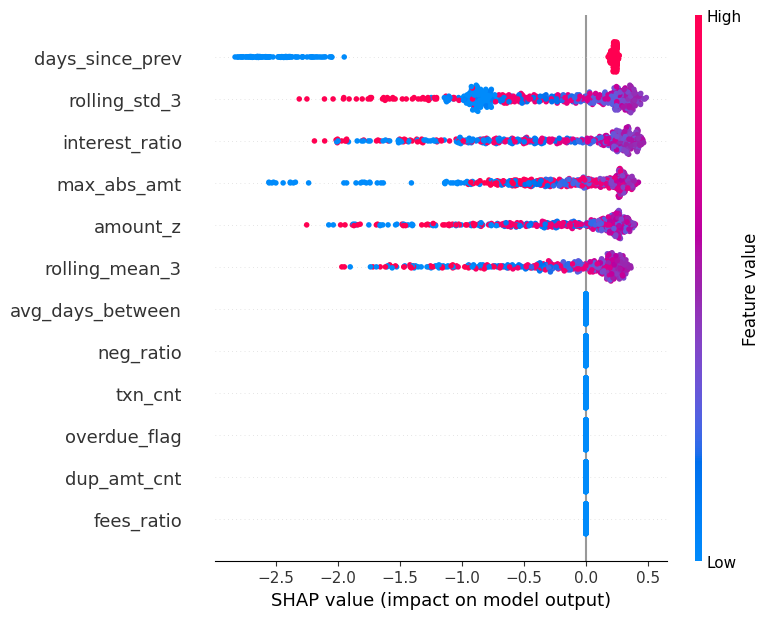

SHAP summary saved → shap_summary_mortgage_iforest.png
Explanation CSV saved → /content/drive/MyDrive/ucla_capstone/mortgage_explain_highrisk.csv


In [ ]:
import os, joblib, pandas as pd, numpy as np
import shap, matplotlib.pyplot as plt

DATA_DIR = '/content/drive/MyDrive/ucla_capstone'
MODEL_PATH = os.path.join(DATA_DIR, 'mortgage_iforest.pkl')
SCORED_FILE = os.path.join(DATA_DIR, 'mortgage_scored.parquet')


df = pd.read_parquet(SCORED_FILE) # pyarrow / fastparquet
pipe = joblib.load(MODEL_PATH) # Pipeline(scaler → IsolationForest)

num_cols = [
    'amount_z','days_since_prev','rolling_mean_3','rolling_std_3',
    'overdue_flag','fees_ratio','interest_ratio','dup_amt_cnt',
    'txn_cnt','neg_ratio','avg_days_between','max_abs_amt'
]

# use top-500 calculate SHAP
top_idx = df['final_score'].nlargest(500).index
X_top = df.loc[top_idx, num_cols].fillna(0)
X_scaled = pipe['sc'].transform(X_top)

explainer = shap.TreeExplainer(pipe['if'])
shap_values = explainer.shap_values(X_scaled)

shap.summary_plot(shap_values, X_top, feature_names=num_cols, show=False)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'shap_summary_mortgage_iforest.png'))
plt.show()
print('SHAP summary saved → shap_summary_mortgage_iforest.png')

# rule hiting column
rule_cols = [c for c in df.columns if c.startswith('R')]
df['rules_hit'] = df[rule_cols].apply(
    lambda r: [c for c in rule_cols if r[c]==1], axis=1
)

# only output HIGH_RISK & FRAUDULENT
exp_cols = ['accountId','transactionId','amount','transactionType',
            'final_score','model_score','rule_score','rules_hit']
out_csv = os.path.join(DATA_DIR,'mortgage_explain_highrisk.csv')
(df[df['label'].isin(['HIGH_RISK','FRAUDULENT'])][exp_cols]
   .to_csv(out_csv, index=False))
print(f'Explanation CSV saved → {out_csv}')


In [ ]:
'''
# ==== 1) Imports & paths ====
import os, joblib, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# 改成你的项目路径
DATA_DIR   = '/content/drive/MyDrive/ucla_capstone'
MODELS_DIR = os.path.join(DATA_DIR, 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

# 优先用带规则的特征文件；没有就用基础特征
CANDIDATES = ['mortgage_features_rules.parquet', 'mortgage_features.parquet']
for name in CANDIDATES:
    path = os.path.join(DATA_DIR, name)
    if os.path.exists(path):
        df = pd.read_parquet(path)
        print(f'Loaded: {name}  ->  shape={df.shape}')
        break
else:
    raise FileNotFoundError('找不到 mortgage_features_rules.parquet 或 mortgage_features.parquet')

# ==== 2) 训练时的“默认特征列清单”（和 Streamlit 中一致）====
num_cols_default = [
    'amount_z','days_since_prev','days_until_next',
    'rolling_mean_3','rolling_std_3','overdue_flag',
    'fees_ratio','interest_ratio','dup_amt_cnt',
    'txn_cnt','neg_ratio','avg_days_between','max_abs_amt'
]
# 和现有列做交集，避免缺列报错
num_cols = [c for c in num_cols_default if c in df.columns]
if len(num_cols) == 0:
    raise RuntimeError('特征列一个都没匹配上，检查你的 features parquet 是否包含这些字段。')
print('Using num_cols:', num_cols)

# 用 DataFrame 拟合（这样 scaler 会记录 feature_names_in_）
X = df[num_cols].fillna(0)

# ==== 3) 训练 Isolation Forest Pipeline ====
CONTAM = 0.03    # mortgage 经验值
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('iforest', IsolationForest(n_estimators=200, contamination=CONTAM, random_state=42))
])
pipe.fit(X)

# ==== 4) 计算训练分布上的阈值（供前端使用）====
raw  = pipe['iforest'].decision_function(pipe['scaler'].transform(X))
mscore = (-raw - (-raw).min()) / ((-raw).max() - (-raw).min() + 1e-12)

# 如果特征表里本身就有 rule_score，就按 0.6/0.4 融合；否则只用模型分
if 'rule_score' in df.columns:
    ALPHA, BETA = 0.6, 0.4
    final = ALPHA*mscore + BETA*df['rule_score'].values
else:
    ALPHA, BETA = 1.0, 0.0
    final = mscore

p90, p97, p99 = np.percentile(final, [90, 97, 99])
print(f'Calibrated cuts: P90={p90:.4f}  P97={p97:.4f}  P99={p99:.4f}')

# ==== 5) 保存到 models/ ====
pipe_path = os.path.join(MODELS_DIR, 'mortgage_iforest.pkl')
meta_path = os.path.join(MODELS_DIR, 'mortgage_feature_meta.pkl')

joblib.dump(pipe, pipe_path)
meta = {'num_cols': num_cols, 'alpha_beta': (float(ALPHA), float(BETA)),
        'pct_cut': (float(p90), float(p97), float(p99))}
joblib.dump(meta, meta_path)

print('✅ Saved:', pipe_path)
print('✅ Saved:', meta_path)

# 小自检：确认是 Pipeline + 有 scaler + 特征数
pp = joblib.load(pipe_path)
print('Pipeline?', isinstance(pp, Pipeline), 'Steps:', list(pp.named_steps.keys()))
print('Scaler n_features_in_ =', getattr(pp.named_steps['scaler'], 'n_features_in_', None))
'''

Loaded: mortgage_features_rules.parquet  ->  shape=(1200, 53)
Using num_cols: ['amount_z', 'days_since_prev', 'days_until_next', 'rolling_mean_3', 'rolling_std_3', 'overdue_flag', 'fees_ratio', 'interest_ratio', 'dup_amt_cnt', 'txn_cnt', 'neg_ratio', 'avg_days_between', 'max_abs_amt']
Calibrated cuts: P90=0.3811  P97=0.4582  P99=0.5086
✅ Saved: /content/drive/MyDrive/ucla_capstone/models/mortgage_iforest.pkl
✅ Saved: /content/drive/MyDrive/ucla_capstone/models/mortgage_feature_meta.pkl
Pipeline? True Steps: ['scaler', 'iforest']
Scaler n_features_in_ = 13
